In [1]:
#!/usr/bin/env python3
# coding: utf-8

# Load dependencies
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

# Parameter estimation - model fitting
from lmfit import minimize
from lmfit import Parameters
from lmfit import fit_report

# For more information about lmfit: https://lmfit.github.io/lmfit-py/
# Highly suggest you read about emcee too: https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.Minimizer.emcee

# Load the data from the Varennes NetZEB Library
Column descriptions:

    # Temperatures
    'T_ext': exterior temp, C
    'T_int': average interior temp, C
    'T_slab: slab temperature, 2 inch from surface, C
    'T_room_air_over_slab': average room temperature over the slab where there is a radiant system, C
    'T_room_air_no_slab': same but where there isn't, C

    # BIPV/T System
    'BIPVT_outletT': temperature at BIPV/T outlet, C
    'BIPVT_dT': ^ minus T_ext, K
    'BIPVT_heat: m*cp*dT = fanstate*rated_flow*density*cp*dT, kW

    # Heating/Cooling
    'geo_heat': m*cp*dT at the geothermal well inlet: how much heat are we rejecting/extracting into the ground, kW
    'heating_total': m*cp*dT at the heat pump condensor/hot side, kW
    'cooling_total': evaporator/cold side, kW
    'Q_slab': heat going into the radiant slab, kW
    'Q_rest_heating': heat going into the air, kW
    'Q_rest': heat - cooling going into the air, kW
    'heating_slab_ratio': heating going into slab over total, rest goes into the air
    'cooling_slab_ratio': cooling going into slab over total, rest goes into the air

    # Windows
    'window_state: 0: closed, 1: open

    # Solar
    'DNI': direct normal irradiance, kW/m^2
    'GHI': global horizontal irradiance, kW/m^2
    'DHI': diffuse horizontal irradiance, kW/m^2
    'solar_projected_PV': unitized solar radiation incident on PV system, kW/m^2

    # Electrical
    'cons': total electrical consumption power, kW
    'prod: total electrical production power, kW
    'cons_noHVAC': approximate electrical consumption without the HVAC (cons - heating_total/4 - cooling_total/3.5), kW

In [2]:
# Load data from csv file, assign index and assure it's a datetime object
df = pd.read_csv("data_varennes_subset.csv.zip", index_col=[0], parse_dates=[0])
print(df.head())

                       T_ext    T_int  BIPVT_outletT  BIPVT_dT  BIPVT_heat  \
Datetime                                                                     
2018-01-01 00:00:00 -21.8566  18.4578       -18.6184    3.2382         0.0   
2018-01-01 00:15:00 -21.8434  18.4086       -18.6614    3.1820         0.0   
2018-01-01 00:30:00 -21.9561  18.3142       -18.6459    3.3102         0.0   
2018-01-01 00:45:00 -22.0408  18.2528       -18.7473    3.2935         0.0   
2018-01-01 01:00:00 -22.1299  18.1697       -18.6353    3.4946         0.0   

                      geo_heat  heating_total  cooling_total  window_state  \
Datetime                                                                     
2018-01-01 00:00:00 -54.118034      38.025668            0.0      0.335996   
2018-01-01 00:15:00 -50.619191      26.322083            0.0      0.336057   
2018-01-01 00:30:00  -9.066210      13.017722            0.0      0.336118   
2018-01-01 00:45:00 -37.896533      10.618306            0.0   

# Approach
Just to make things a bit simple, we will train the model on one day of data and test it on the following day; both days will be during the week to assume a consistent occupancy schedule and setpoint schedule.

We will try different models to see whether we're improving.

We will represent models 3, 4 and 5 in a simplified discrete time-invariant state-space formulation; it's much cleaner, I promise!
 
### Model 1: Naive
$$ T_{int}(t+1) = \alpha T_{int}(t) + \phi T_{ext}(t) $$

### Model 2: Naive Difference with exterior
$$ T_{int}(t+1) = \alpha [T_{ext}(t) - T_{int}(t)] $$

### Model 3: Delta temperature
$$
\begin{align}
T_{int}(t+1) - T_{int}(t) &= \alpha [T_{ext}(t) - T_{int}(t)] \\
T_{int}(t+1) &= T_{int}(t) + \alpha [T_{ext}(t) - T_{int}(t)] \\
T_{int}(t+1) &= (1-\alpha) T_{int}(t) + \alpha T_{ext}(t) \\
\end{align}
$$

### Model 4: Delta temperature
$$ T_{int}(t+1) - T_{int}(t) = \alpha [T_{ext}(t) - T_{int}(t)] + \beta \dot{Q}_{\textrm{cons-noHVAC}} $$

### Model 5: Delta temperature
$$ T_{int}(t+1) - T_{int}(t) = \alpha [T_{ext}(t) - T_{int}(t)] + \beta \dot{Q}_{\textrm{HVAC}} + \gamma \textrm{GHI} $$

### Fitting the model using mean squared error (MSE)
$$ \min_{\alpha, \beta, \gamma}{\sum_{i=t}^{data}{(T_{int}(i) - \hat{T}_{int}(i))^2}} $$

---
### Model 1: Naive
$$ T_{int}(t+1) = \alpha T_{int}(t) + \phi T_{ext}(t) $$

In [3]:
# 2018-01-16: Tuesday
df_train = df["2018-01-16"].copy()
df_test = df["2018-01-17"].copy()

# TRAIN
# input
Tint_t_train = df_train["T_int"].iloc[:-1].values
Text_t_train = df_train["T_ext"].iloc[:-1].values
# output
Tint_tp1_train = df_train["T_int"].iloc[1:].values

# TEST
# input
Tint_t_test = df_test["T_int"].iloc[:-1].values
Text_t_test = df_test["T_ext"].iloc[:-1].values
# output
Tint_tp1_test = df_test["T_int"].iloc[1:].values

In [4]:
# Optimization function
def opti_fun(
    params: Parameters,
    Tint_t_train: np.ndarray,
    Text_t_train: np.ndarray,
    Tint_tp1_train: np.ndarray,
) -> np.ndarray:

    Tint_tp1_train_pred = params["alpha"] * Tint_t_train + params["phi"] * Text_t_train

    error = Tint_tp1_train - Tint_tp1_train_pred
    return error  # least squares solved will square and sum for us :)


# Parameters we are trying to fits
params = Parameters()
params.add("alpha", value = 0.5)
params.add("phi", value = 0.5)

# Additional information needed to describe the problem
opti_kwargs = {
    "Tint_t_train": Tint_t_train,
    "Text_t_train": Text_t_train,
    "Tint_tp1_train": Tint_tp1_train,
}

# Run!
results = minimize(fcn=opti_fun, params=params, method='leastsq', kws=opti_kwargs)

# Print results
print(fit_report(results))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 95
    # variables        = 2
    chi-square         = 0.31744548
    reduced chi-square = 0.00341339
    Akaike info crit   = -537.625977
    Bayesian info crit = -532.518224
[[Variables]]
    alpha:  1.00260422 +/- 0.00133209 (0.13%) (init = 0.5)
    phi:    0.00411429 +/- 0.00213328 (51.85%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, phi) =  0.974


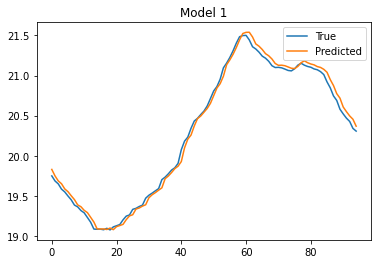

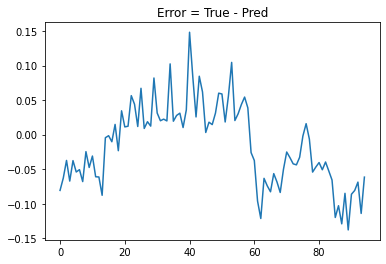

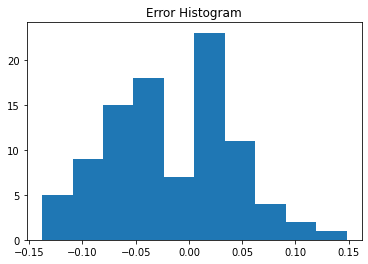

In [5]:
# Get optimal values
alpha = results.params["alpha"].value
phi = results.params["phi"].value

# Let's see how it performs
Tint_tp1_test_pred = alpha * Tint_t_test + phi * Text_t_test

# Place in correct location (remember, this is for t+1!)
# error = true - predicted
error = Tint_tp1_test - Tint_tp1_test_pred

plt.plot(Tint_tp1_test, label = "True")
plt.plot(Tint_tp1_test_pred, label = "Predicted")
plt.title("Model 1")
plt.legend()
plt.show()

plt.plot(error)
plt.title("Error = True - Pred")
plt.show()

plt.hist(error, bins=10)
plt.title("Error Histogram")
plt.show()

---
### Model 1: Naive (attempt 2!)
$$ 
\min_{\alpha, \beta, \gamma}{\sum_{i=t}^{nt}{(T_{int}(i) - \hat{T}_{int}(i))^2}} \\
\begin{align}
\textrm{s.t.} \\
& \hat{T}_{int}(1) = \alpha T_{int}(0) + \phi T_{ext}(0) \\
& \hat{T}_{int}(t+1) = \alpha \hat{T}_{int}(t) + \phi T_{ext}(t) ~~ | ~ t = 1, ~..., ~nt-1
\end{align}
$$

In [6]:
# 2018-01-16: Tuesday
df_train = df["2018-01-16"].copy()
df_test = df["2018-01-17"].copy()

# TRAIN
# input
Tint_t_train = df_train["T_int"].iloc[:-1].values
Text_t_train = df_train["T_ext"].iloc[:-1].values
# output
Tint_tp1_train = df_train["T_int"].iloc[1:].values

# TEST
# input
Tint_t_test = df_test["T_int"].iloc[:-1].values
Text_t_test = df_test["T_ext"].iloc[:-1].values
# output
Tint_tp1_test = df_test["T_int"].iloc[1:].values

In [7]:
# Optimization function
def opti_fun(
    params: Parameters,
    Tint_t_train: np.ndarray,
    Text_t_train: np.ndarray,
    Tint_tp1_train: np.ndarray,
) -> np.ndarray:
    
    nt = len(Tint_tp1_train)
    Tint_tp1_train_pred = np.zeros_like(Tint_tp1_train)
    
    # NOTE CAREFUL: first entry in Tint_tp1_train_pred (idx=0) is for t=1!
    for t in range(nt):
        if t == 0:
            Tint_tp1_train_pred[t] = params["alpha"] * Tint_t_train[t] + params["phi"] * Text_t_train[t]
        else:
            Tint_tp1_train_pred[t] = params["alpha"] * Tint_tp1_train_pred[t-1] + params["phi"] * Text_t_train[t]
        
    error = Tint_tp1_train - Tint_tp1_train_pred
    return error  # least squares solved will square and sum for us :)


# Parameters we are trying to fits
params = Parameters()
params.add("alpha", value = 0.5)
params.add("phi", value = 0.5)

# Additional information needed to describe the problem
opti_kwargs = {
    "Tint_t_train": Tint_t_train,
    "Text_t_train": Text_t_train,
    "Tint_tp1_train": Tint_tp1_train,
}

# Run!
results = minimize(fcn=opti_fun, params=params, method='leastsq', kws=opti_kwargs)

# Print results
print(fit_report(results))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 95
    # variables        = 2
    chi-square         = 28.9915804
    reduced chi-square = 0.31173742
    Akaike info crit   = -108.752786
    Bayesian info crit = -103.645033
[[Variables]]
    alpha:  1.00308742 +/- 7.0862e-04 (0.07%) (init = 0.5)
    phi:    0.00398727 +/- 0.00109073 (27.36%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, phi) =  0.998


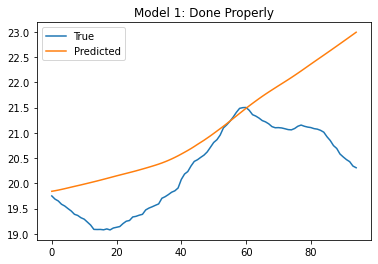

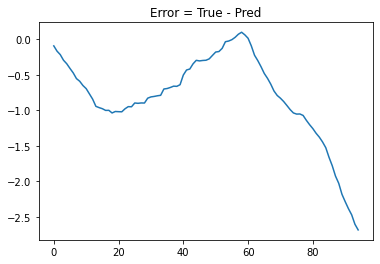

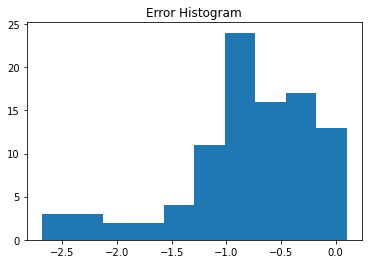

In [8]:
# Get optimal values
alpha = results.params["alpha"].value
phi = results.params["phi"].value

# Let's see how it performs
nt = len(Tint_tp1_test)
Tint_tp1_test_pred = np.zeros_like(Tint_tp1_test)

# NOTE CAREFUL: first entry in Tint_tp1_test_pred (idx=0) is for t=1!
for t in range(nt):
    if t == 0:
        Tint_tp1_test_pred[t] = alpha * Tint_t_test[t] + phi * Text_t_test[t]
    else:
        Tint_tp1_test_pred[t] = alpha * Tint_tp1_test_pred[t-1] + phi * Text_t_test[t]
    
# Place in correct location (remember, this is for t+1!)
# error = true - predicted
error = Tint_tp1_test - Tint_tp1_test_pred

plt.plot(Tint_tp1_test, label = "True")
plt.plot(Tint_tp1_test_pred, label = "Predicted")
plt.title("Model 1: Done Properly")
plt.legend()
plt.show()

plt.plot(error)
plt.title("Error = True - Pred")
plt.show()

plt.hist(error, bins=10)
plt.title("Error Histogram")
plt.show()

---
### Model 2
Do this as an execise.

Do you see an improvement over Model 1? What does the fit look like? Is the model able to follow the peaks or does it draw a line through the middle?

---
### Model 3
$$ 
\min_{\alpha, \beta, \gamma}{\sum_{i=t}^{nt}{(T_{int}(i) - \hat{T}_{int}(i))^2}} \\
\begin{align}
\textrm{s.t.} \\
& A = 1 - \alpha \\
& C = \alpha \\
& \hat{T}_{int}(1) = A T_{int}(0) + C T_{ext}(0) \\
& \hat{T}_{int}(t+1) = A \hat{T}_{int}(t) + C T_{ext}(t) ~~ | ~ t = 1, ~..., ~nt-1
\end{align}
$$

In [9]:
def pred_recursive(
    A,
    X_initial,
    B = None,
    U = None,
    C = None,
    W = None,
):
    """
    Simplified approach where X is the estimated state:
    X(0) = X_initial
    X(t+1) = A*X(t) + B*U(t) + C*W(t)
    """
    # NOTE CAREFUL: first entry in predicted X (idx=0) is for t=1!
    # Only exogenous inputs
    if (B is None) and (C is not None):
        X = np.zeros((len(W), A.shape[1]))
        X[0,] = A @ X_initial + C @ W[0,]
        for t in range(1, len(W)):
            X[t,] = A @ X[t-1,] + C @ W[t,]
        return X

    # Only control inputs
    if (B is not None) and (C is None):
        X = np.zeros((len(U), A.shape[1]))
        X[0,] = A @ X_initial + B @ U[0,]
        for t in range(1, len(U)):
            X[t,] = A @ X[t-1,] + B @ U[t,]
        return X

    # Both control and exogenous inputs
    if (B is not None) and (C is not None):
        X = np.zeros((len(U), A.shape[1]))
        X[0,] = A @ X_initial + B @ U[0,] + C @ W[0,]
        for t in range(1, len(U)):
            X[t,] = A @ X[t-1,] + B @ U[t,] + C @ W[t,]
        return X


def state_space_pred_recursive_return_error(
    params: Parameters,
    X_true: np.ndarray,
    U: np.ndarray = None,
    W: np.ndarray = None,
    build_ABC = None,
) -> np.ndarray:
    """ State-space model formulation recursive prediction returning error."""

    # Build ABC
    A, B, C = build_ABC(params)

    # Run predictions
    X_initial = X_train[0, np.newaxis]  # keep it as a matrix
    X_pred = pred_recursive(A, X_initial, B, U, C, W)
    
    # Get error and ship
    error = X_true[1:] - X_pred
    return error  # least squares solved will square and sum for us :)

In [10]:
# 2018-01-16: Tuesday
df_train = df["2018-01-16"].copy()
df_test = df["2018-01-17"].copy()

# Define our dependent/independent variables
X_cols = ["T_int"]  # state_columns
W_cols = ["T_ext"]  # exogenous_columns

# TRAIN
X_train = df_train[X_cols].values
W_train = df_train[W_cols].iloc[:-1].values

# TEST
X_test = df_test[X_cols].values
W_test = df_test[W_cols].iloc[:-1].values


In [11]:
def build_ABC_model_3(params):
    # Place parameters in A, B, C matrices
    A = np.array([[1 - params["alpha"]]])
    B = None
    C = np.array([[params["alpha"]]])
    return A, B, C

# Parameters we are trying to fits
params = Parameters()
params.add("alpha", value = 0.5)

# Additional information needed to describe the problem
opti_kwargs = {
    "X_true": X_train,
    "W": W_train,
    "build_ABC": build_ABC_model_3,  # pass the ABC generator
}

# Run!
results = minimize(
    fcn = state_space_pred_recursive_return_error, 
    params = params, 
    method = 'leastsq', 
    kws = opti_kwargs
)

# Print results
print(fit_report(results))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 95
    # variables        = 1
    chi-square         = 34.2808527
    reduced chi-square = 0.36468992
    Akaike info crit   = -94.8325427
    Bayesian info crit = -92.2786658
[[Variables]]
    alpha: -3.1383e-04 +/- 3.3729e-05 (10.75%) (init = 0.5)


A: [[1.00031383]]
B: None
C: [[-0.00031383]]


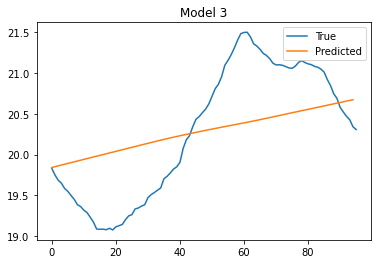

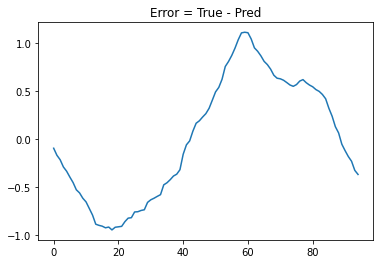

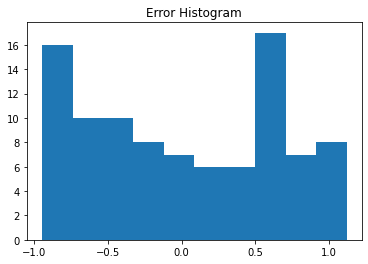

In [12]:
# Assign optimized results.params to params
params = results.params

# build_ABC_model_3
A, B, C = build_ABC_model_3(params)
print(f"A: {A}")
print(f"B: {B}")
print(f"C: {C}")

# Run predictions
X_initial = X_test[0, np.newaxis]  # keep it as a matrix
X_pred = pred_recursive(A, X_initial, C, W_test)

# Get error and ship
error = X_test[1:] - X_pred

# Plot results
plt.plot(X_test, label = "True")
plt.plot(X_pred, label = "Predicted")
plt.title("Model 3")
plt.legend()
plt.show()

plt.plot(error)
plt.title("Error = True - Pred")
plt.show()

plt.hist(error, bins=10)
plt.title("Error Histogram")
plt.show()

---
### Model 4
Do this as an execise.

Do you see an improvement over Model 3? 
What does the fit look like? 
Is the model able to follow the peaks or does it draw a line through the middle?

Think about the degrees of freedom.


---
### Model 5: Delta temperature
$$ T_{int}(t+1) - T_{int}(t) = \alpha [T_{ext}(t) - T_{int}(t)] + \beta \dot{Q}_{\textrm{HVAC}} + \gamma \textrm{GHI} $$

$$ 
\min_{\alpha, \beta, \gamma}{\sum_{i=t}^{nt}{(T_{int}(i) - \hat{T}_{int}(i))^2}} \\

\begin{align}
\textrm{s.t.} \\
& A = [[1 - \alpha]] \\
& B = [[\beta]] \\
& C = [[\alpha, \gamma]] \\
& \hat{T}_{int}(1) = A T_{int}(0) + B \dot{Q}_{\textrm{HVAC}}(0) + C [T_{ext}(0), \textrm{GHI}] \\
& \hat{T}_{int}(t+1) = A \hat{T}_{int}(t) + B \dot{Q}_{\textrm{HVAC}}(t) + C [T_{ext}(t), \textrm{GHI}] ~~ | ~ t = 1, ~..., ~nt-1 \\
\end{align}
$$

Matrices $A$, $B$, and $C$ are matrices with number of rows matching the number of states and columns matching features.

In [13]:
# 2018-01-16: Tuesday
df_train = df["2018-01-16"].copy()
df_test = df["2018-01-17"].copy()

# Define our dependent/independent variables
X_cols = ["T_int"]  # state_columns
U_cols = ["heating_total"]  # control_columns
W_cols = ["T_ext", "GHI"]  # exogenous_columns

# TRAIN
X_train = df_train[X_cols].values
U_train = df_train[U_cols].iloc[:-1].values
W_train = df_train[W_cols].iloc[:-1].values

# TEST
X_test = df_test[X_cols].values
U_test = df_test[U_cols].iloc[:-1].values
W_test = df_test[W_cols].iloc[:-1].values

In [14]:
def build_ABC_model_5(params):
    # Place parameters in A, B, C matrices
    A = np.array([[1 - params["alpha"]]])
    B = np.array([[params["beta"]]])
    C = np.array([[params["alpha"], params["gamma"]]])
    return A, B, C

# Parameters we are trying to fits
params = Parameters()
params.add("alpha", value = 0.5)
params.add("beta", value = 0.5)
params.add("gamma", value = 0.5)

# Additional information needed to describe the problem
opti_kwargs = {
    "X_true": X_train,
    "U": U_train,
    "W": W_train,
    "build_ABC": build_ABC_model_5,  # pass the ABC generator
}

# Run!
results = minimize(
    fcn = state_space_pred_recursive_return_error, 
    params = params, 
    method = 'leastsq', 
    kws = opti_kwargs
)

# Print results
print(fit_report(results))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 95
    # variables        = 3
    chi-square         = 12.5116919
    reduced chi-square = 0.13599665
    Akaike info crit   = -186.585267
    Bayesian info crit = -178.923636
[[Variables]]
    alpha:  5.3596e-04 +/- 1.1918e-04 (22.24%) (init = 0.5)
    beta:   1.2117e-04 +/- 1.2698e-04 (104.79%) (init = 0.5)
    gamma:  0.30312252 +/- 0.05008928 (16.52%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  =  0.845
    C(beta, gamma)  = -0.841
    C(alpha, gamma) = -0.438


A: [[0.99946404]]
B: [[0.00012117]]
C: [[0.00053596 0.30312252]]


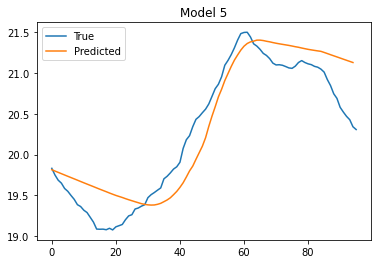

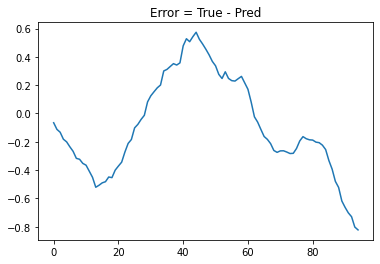

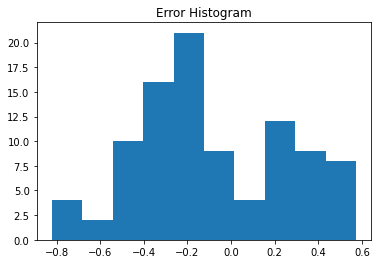

In [16]:
# Assign optimized results.params to params
params = results.params

# build_ABC_model_3
A, B, C = build_ABC_model_5(params)
print(f"A: {A}")
print(f"B: {B}")
print(f"C: {C}")

# Run predictions
X_initial = X_test[0, np.newaxis]  # keep it as a matrix
X_pred = pred_recursive(A, X_initial, B, U_test, C, W_test)

# Get error and ship
error = X_test[1:] - X_pred

# Plot results
plt.plot(X_test, label = "True")
plt.plot(X_pred, label = "Predicted")
plt.title("Model 5")
plt.legend()
plt.show()

plt.plot(error)
plt.title("Error = True - Pred")
plt.show()

plt.hist(error, bins=10)
plt.title("Error Histogram")
plt.show()

## Conclusion
+ What's going on as we add terms?
+ Can we put the features arbitrarily?
+ How are we injecting our domain expertise into the problem? Comment on (a) the feature engineering, (b) the model structure and (c) the loss function.
+ What would a neural network have done?
+ What would happen if we used a lot more data?
+ If we had 2 years of data, how would you reformulate the fit problem?
+ If there's no more information left in the residual (error), what would it look like?
+ What's the interpretation of the A, B and C matrices?
+ In the general state-space representation, there is the concept of hidden states, what are we assuming here? 
+ If we wanted to add hidden states, what would they represent?